In [1]:
import ebf
import healpix_util as hu
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import healpy as hp
import astropy.stats as st
import astropy.visualization as av
import pickle
import gala.coordinates as gc

In [2]:
# simple code to make a grid that you can scroll thorugh nicely
# by Lachlan 

def getGrid(n):
    res = np.zeros((n,n))
    for row in xrange(n):
        for col in xrange(n):
            if (col%2==0):
                maxRowNum = n*(col+1)
                res[row][col] = maxRowNum - (n - (row+1))
            else:
                maxRowNum = n*col + 1
                res[row][col] = maxRowNum + (n - (row+1))
    return res

In [3]:
def plotPixels(x, y, pixel_array, mapSky, pixelImages, plotEach=False, 
               xlim=(-2, 2.5), ylim=(2, -1), vmin=0.01, vmax=10., 
               xlabel='log distance', ylabel='log proper motion', 
               fignameAll='pofd_allPixels.pdf', fignameEachpre='pofd', 
               bins=100, normed=False, norm=None, cmap='Greys', dynRange=100., grid=False, npixels=None, nside=1):
    if npixels is None: npixels = np.max(pixel_array)
    fig, axes = plt.subplots(4*nside, 3*nside, figsize=(7*nside, 7*nside))
    axes = axes.flatten()
    if plotEach: fignow, axesnow = plt.subplots(1, 2, figsize=(10, 5))
    #loop over pixel on sky
    for ax, pixel_index in zip(axes, range(np.max(pixel_array)+1)):
        axesnow[0].cla()
        axesnow[1].cla()
        index = pixel_array == pixel_index
        if np.sum(index):
            for axis in [ax, axesnow[0]]:
                counts, xedges, yedges = np.histogram2d(x[index], y[index], bins=bins, normed=normed)
                if norm == 'lognorm': 
                    minhist = np.min(counts[counts > 0])
                    if dynRange is not None:
                        norm=mpl.colors.LogNorm(vmin=minhist, vmax=minhist*dynRange)
                    else:
                        norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
                axis.imshow(counts, origin='lower', extent=[np.min(xedges), np.max(xedges), np.min(yedges), np.max(yedges)], cmap=cmap, norm=norm)
                axis.set_xlim(xlim)
                axis.set_ylim(ylim)
                axis.set_xlabel(xlabel)
                axis.set_ylabel(ylabel)
                axis.grid()
            axesnow[1].imshow(mapSky, origin='lower', extent=[-180, 180, -90, 90])
            axesnow[1].imshow(pixelImages[pixel_index], origin='lower', cmap='Greys', alpha=0.3, extent=[-180, 180, -90, 90])
            axesnow[1].set_xlabel('l')
            axesnow[1].set_ylabel('b')
            fignow.savefig('{0}_{1:03d}.pdf'.format(fignameEachpre, pixel_index), rasterized=True)
    fig.savefig(fignameAll)
    plt.close(fig)
    plt.close(fignow)

In [100]:
#do data first, then model, then delta 
Model = True
Data = True
Delta = False
Test = False

In [101]:
if Model: 
    dustCoeff = {'B': 3.626,
             'V': 2.742,
             'g': 3.303,
             'r': 2.285,
             'i': 1.698,
             'J': 0.709,
             'H': 0.449,
             'K': 0.302,
             'W1':0.18,
             'W2':0.16,
             'G': 2.55}
    #datafile = 'sdssHalo.ebf'
    datafile = 'sdssgalaxyHalo_SH.ebf'
    #datafile = '../GalaxiaData/sdssgalaxy_1percent.ebf'
    #datafile = '../GalaxiaData/sdssHalo.ebf'
    data = ebf.read(datafile, '/')
    print data.keys()
    appmagr = data['sdss_r'] + 5.*np.log10(data['rad']*1000./10.) + data['exbv_schlegel']*dustCoeff['r']
    appCut = (appmagr > 16) & (appmagr < 20)

    c = coord.Galactic(u=data['px'][appCut]*u.kpc, v=data['py'][appCut]*u.kpc, w=data['pz'][appCut]*u.kpc,
                     U=data['vx'][appCut]*u.km/u.s, V=data['vy'][appCut]*u.km/u.s, W=data['vz'][appCut]*u.km/u.s,
                     representation=coord.CartesianRepresentation, differential_cls=coord.CartesianDifferential)
    c.set_representation_cls(coord.SphericalRepresentation, s=coord.SphericalCosLatDifferential)

    l_m = data['glon'][appCut]
    b_m = data['glat'][appCut]
    #ra_m = data['ra'][appCut]
    #dec_m = data['dec'][appCut]
    pm = np.sqrt(c.pm_b**2. + c.pm_l_cosb**2.)
    pmb_m = np.random.normal(loc=c.pm_b, scale=2)
    pml_m = np.random.normal(loc=c.pm_l_cosb, scale=2)
    figname_pre = 'galaxia_'
    appmag = data['sdss_g'] + 5.*np.log10(data['rad']*1000./10.) + data['exbv_schlegel']*dustCoeff['g']
    data_m = data

['rad', 'exbv_solar', 'teff', 'sdss_g', 'mag2', 'mag1', 'mag0', 'sdss_r', 'sdss_u', 'satid', 'vx', 'vy', 'vz', 'sdss_z', 'mtip', 'log', 'pz', 'px', 'py', 'feh', 'exbv_schlegel', 'sdss_i', 'lum', 'exbv_schlegel_inf', 'mact', 'glon', 'popid', 'glat', 'alpha', 'center', 'partid', 'age', 'grav', 'smass', 'fieldid']


In [6]:
if Data:
    cache_file = 'gaiasdssHaloNew_30b.pkl'
    with open(cache_file, 'rb') as f:
        data = pickle.load(f)
    xkey = 's_ra1'
    ykey = 's_dec1'
    pmxkey = 'pmra_new'
    pmykey = 'pmdec_new' 
    #l = data['l']
    #b = data['b']
    c = coord.ICRS(ra=data[xkey]*u.deg, dec=data[ykey]*u.deg, 
                   pm_ra_cosdec=data[pmxkey]*u.mas/u.yr, pm_dec=data[pmykey]*u.mas/u.yr)
    cGal = c.transform_to(coord.Galactic)
    pml = cGal.pm_l_cosb.value
    pmb = cGal.pm_b.value
    l = cGal.l.value
    b = cGal.b.value
    ra = data[xkey]
    dec = data[ykey]
    
    figname_pre = 'sdss_'
    appmag = data['phot_g_mean_mag']

NameError: name 'ra' is not defined

In [7]:
if Data:
    xkey = 's_ra1'
    ykey = 's_dec1'
    pmxkey = 'pmra_new'
    pmykey = 'pmdec_new' 
    #l = data['l']
    #b = data['b']
    c = coord.ICRS(ra=data[xkey]*u.deg, dec=data[ykey]*u.deg, 
                   pm_ra_cosdec=data[pmxkey]*u.mas/u.yr, pm_dec=data[pmykey]*u.mas/u.yr)
    cGal = c.transform_to(coord.Galactic)
    pml = cGal.pm_l_cosb.value
    pmb = cGal.pm_b.value
    l = cGal.l.value
    b = cGal.b.value
    ra = data[xkey]
    dec = data[ykey]
    
    figname_pre = 'sdss_'
    appmag = data['phot_g_mean_mag']

In [ ]:
if Delta:
    figname_pre = 'delta_'

    print len(l), len(l_m)
    print float(len(l))/len(l_m)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


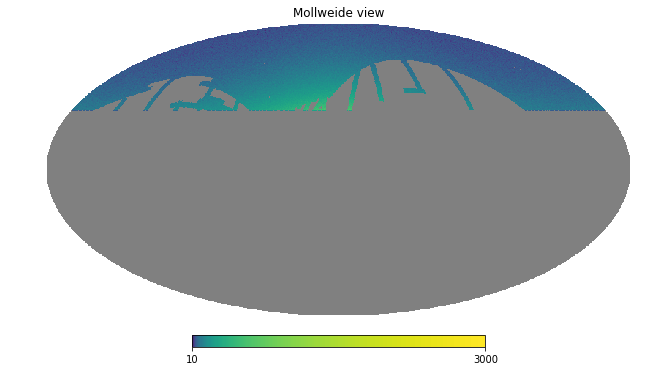

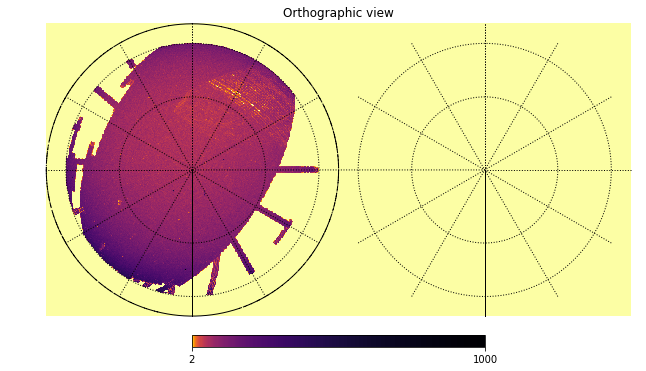

In [103]:
#for visualizing all data on the sky 
nside = 256
hpixMap = hu.HealPix("ring", nside)

if Model:
    figname_pre = 'galaxia_'
    pixnums = hpixMap.eq2pix(l, b)
    omap = np.bincount(pixnums, minlength=hpixMap.npix)
    pixnumswanted = np.where(omap > 1)
    pixnums_m = hpixMap.eq2pix(l_m, b_m)

    fp_indices = np.in1d(pixnums_m, pixnumswanted)
    pixnums_m = hpixMap.eq2pix(l_m[fp_indices], b_m[fp_indices])
    mmap = np.bincount(pixnums_m, minlength=hpixMap.npix)
    mapSky = hp.mollview(mmap, return_projected_map=True, min=10, max=3e3, norm='log')
    plt.savefig('galaxia_allsky.pdf')

    l_m = l_m[fp_indices]
    b_m = b_m[fp_indices]
    pmb_m = pmb_m[fp_indices]
    pml_m = pml_m[fp_indices]

    
if Data:
    import healpy.newvisufunc as hpnew
    figname_pre = 'sdss_'
    pixnums = hpixMap.eq2pix(l, b)
    omap = np.bincount(pixnums, minlength=hpixMap.npix)
    mapSky = hp.orthview(omap+0.5, rot=(0, 90, 0), norm='log', cmap='inferno_r', min=2, max=1e3)
    hp.graticule()
    #mapSky = hpnew.mollview(omap, flip='astro', 
    #                    graticule=True, graticule_labels=True, rot=(0, 90, 30))
    #hp.graticule(coord='E')
    #hp.projplot([120, 120, 120],[-90, 0, 90], rot=(120, 0, 0), lonlat=True, lw=2)
    #hp.projplot(0, 180, rot=(120, 0, 0), lonlat=True)
    plt.savefig('sdss_allsky.pdf')

if Delta:
    figname_pre = 'delta_'
    pixnums_m = hpixMap.eq2pix(l_m, b_m)
    mmap = np.bincount(pixnums_m, minlength=hpixMap.npix)
    pixnums = hpixMap.eq2pix(l, b)
    omap = np.bincount(pixnums, minlength=hpixMap.npix)
    mapSky = hp.mollview(omap - mmap +0.5, return_projected_map=True, norm='linear')
    plt.savefig('delta_allsky.pdf')


In [97]:
sky = coord.ICRS(ra=data[xkey]*u.deg, dec=data[ykey]*u.deg, pm_ra_cosdec=data[pmxkey]*u.mas/u.yr, pm_dec=data[pmykey]*u.mas/u.yr)
gd1 = sky.transform_to(gc.GD1)


(array([  40978.,   42990.,   45278.,   47180.,   50051.,   52517.,
          55224.,   58073.,   61697.,   64640.,   68387.,   72352.,
          76578.,   81036.,   86127.,   90523.,   95915.,  102398.,
         107987.,  113682.,  121943.,  128521.,  136569.,  145743.,
         154235.,  164695.,  174042.,  184803.,  196407.,  207438.,
         220388.,  232729.,  245427.,  259290.,  271076.,  284028.,
         297876.,  308522.,  321184.,  332706.,  341874.,  349973.,
         354777.,  360947.,  363073.,  362382.,  358835.,  353429.,
         344505.,  332054.,  315365.,  299098.,  278385.,  258870.,
         238880.,  220544.,  202608.,  186135.,  171014.,  156225.,
         144255.,  131053.,  119638.,  109821.,   99686.,   91557.,
          82693.,   74440.,   68153.,   61697.,   56558.,   50834.,
          45945.,   42100.,   38592.,   34765.,   31596.,   29228.,
          26518.,   24227.,   22238.,   20425.,   19017.,   17157.,
          15840.,   14619.,   13654.,   12760., 

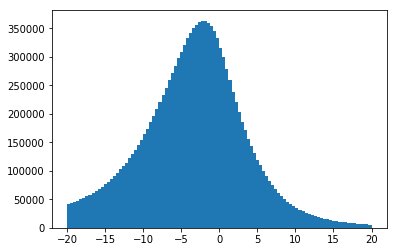

In [80]:
plt.hist(gd1.pm_phi1_cosphi2.value, bins=100, range=[-20, 20])

(-30, 30)

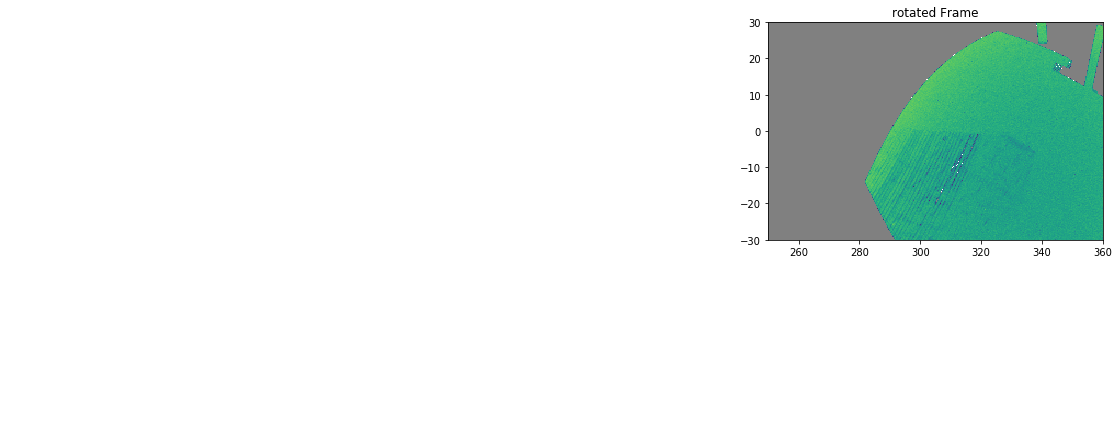

In [113]:
plt.hist2d(gd1.phi1.value, gd1.phi2.value, norm=mpl.colors.LogNorm(), bins=1000)
plt.title('rotated Frame')
plt.xlim(250, 360)
plt.ylim(-30, 30)

14495779


Text(0,0.5,u'phi2')

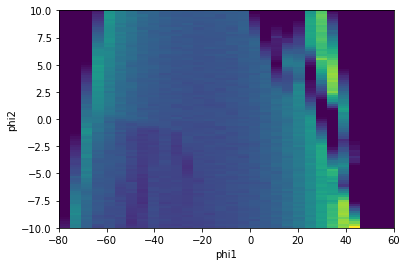

In [125]:
hpixMapPix = hu.HealPix('ring', 256)
pmalpha_center = -6.0*u.mas/u.yr
pmdelta_center = -11.*u.mas/u.yr
radius = 4.*u.mas/u.yr
extent_along_stream = 1000
width_of_stream = 1000
indices = (np.abs(gd1.pm_phi1_cosphi2.value) < extent_along_stream) & (np.abs(gd1.pm_phi2.value) < width_of_stream) 
#indices = (data[pmxkey]*u.mas/u.yr-pmalpha_center)**2. + (data[pmykey]*u.mas/u.yr-pmdelta_center)**2. < radius**2.
print np.sum(indices)
#pixnumbers = hpixMapPix.eq2pix(gd1.phi1[indices], gd1.phi2[indices])
#omap = np.bincount(pixnumbers, minlength=hpixMapPix.npix)
#mapSky = hp.mollview(omap+0.5, min=1, max=1000, norm='log', cmap='inferno_r', return_projected_map=True)
#mapSky = hp.mollview(omap+0.5, return_projected_map=True, norm='log', rot=(0, 100, 30))
bins = [np.linspace(-80, 60, 1000), (-70, 30, 1000)]
#fig, ax = plt.subplots()
x = gd1.phi1[indices].value
y = gd1.phi2[indices].value
x[x > 180.] = x[x > 180.] - 360.
plt.hist2d(x, y, range= [[-80, 60], [-10, 10]], bins=[30,100] )
plt.xlabel('phi1')
plt.ylabel('phi2')
#plt.imshow(mapSky, origin='lower', cmap='plasma_r', norm=mpl.colors.LogNorm(vmin=1, vmax=1000))


Text(0.5,1,u'gd1')

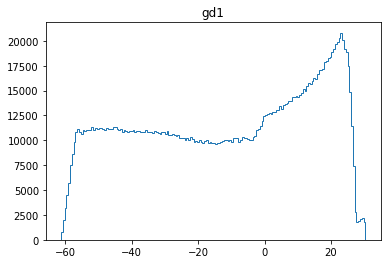

In [129]:
ind2=(x > -40) & (x < -20)
plt.hist(y[ind2], bins=170, histtype='step')
plt.title('gd1')

(array([[ 185.,  185.,  201., ...,  140.,  139.,  154.],
        [ 181.,  220.,  225., ...,  160.,  150.,  134.],
        [ 221.,  241.,  238., ...,  164.,  147.,  177.],
        ..., 
        [  20.,   19.,   28., ...,   12.,   12.,   17.],
        [  27.,   21.,   29., ...,   15.,   21.,   10.],
        [  15.,   24.,   20., ...,   10.,   16.,   13.]]),
 array([-10. ,  -9.8,  -9.6,  -9.4,  -9.2,  -9. ,  -8.8,  -8.6,  -8.4,
         -8.2,  -8. ,  -7.8,  -7.6,  -7.4,  -7.2,  -7. ,  -6.8,  -6.6,
         -6.4,  -6.2,  -6. ,  -5.8,  -5.6,  -5.4,  -5.2,  -5. ,  -4.8,
         -4.6,  -4.4,  -4.2,  -4. ,  -3.8,  -3.6,  -3.4,  -3.2,  -3. ,
         -2.8,  -2.6,  -2.4,  -2.2,  -2. ,  -1.8,  -1.6,  -1.4,  -1.2,
         -1. ,  -0.8,  -0.6,  -0.4,  -0.2,   0. ,   0.2,   0.4,   0.6,
          0.8,   1. ,   1.2,   1.4,   1.6,   1.8,   2. ,   2.2,   2.4,
          2.6,   2.8,   3. ,   3.2,   3.4,   3.6,   3.8,   4. ,   4.2,
          4.4,   4.6,   4.8,   5. ,   5.2,   5.4,   5.6,   5.8,   6. ,
   

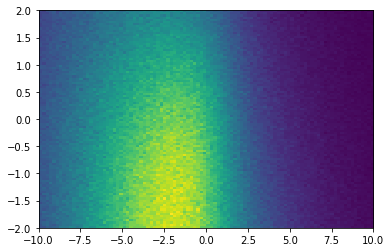

In [133]:
plt.hist2d(gd1.pm_phi1_cosphi2.value, gd1.pm_phi2.value, range=[[-10, 10],[-2,2]], bins=100)

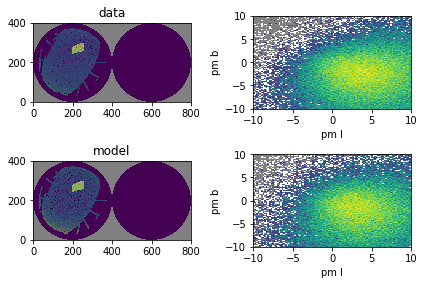

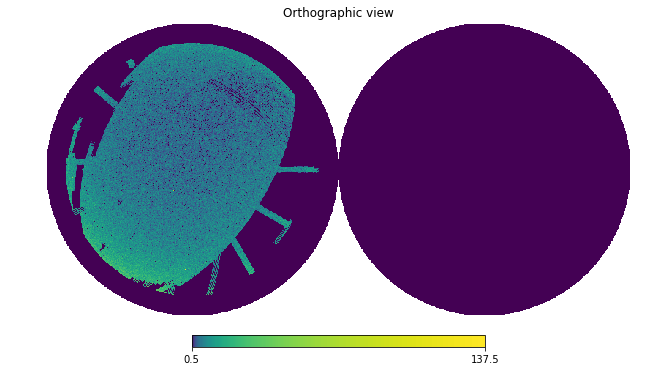

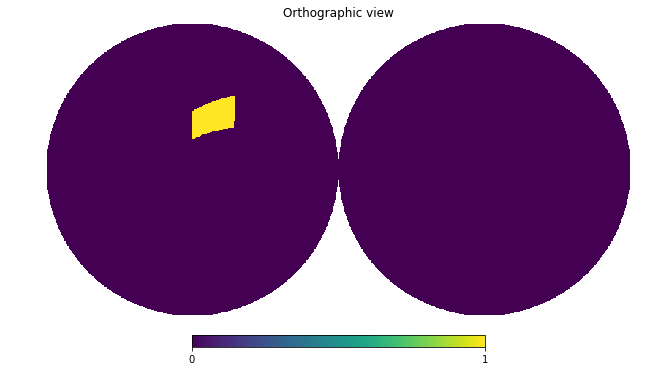

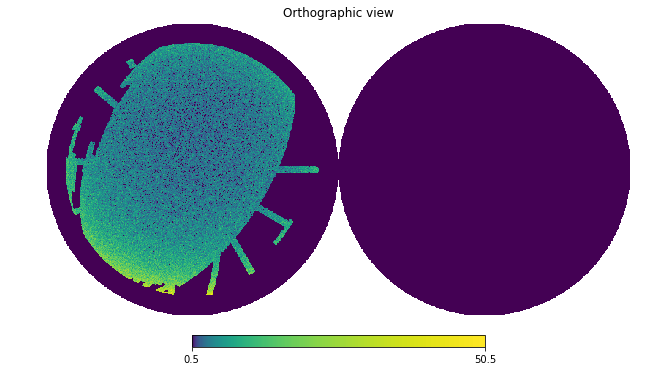

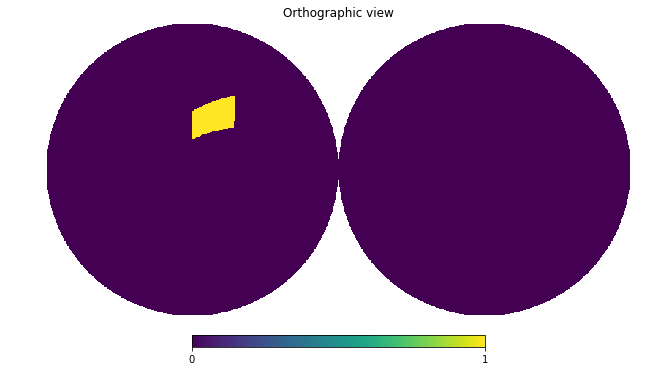

In [105]:
fig, axes = plt.subplots(2, 2)
lwanted = 0
bwanted = 110
nside = 1024
hpixMapViz = hu.HealPix("ring", nside)
hpixMapPix = hu.HealPix('ring', 4)
npix = hpixMapPix.npix
p  = hpixMapPix.eq2pix(lwanted, bwanted)
bins = [np.linspace(-10, 10, 100), np.linspace(-10, 10, 100)]
for i, (x, y, px, py, label) in enumerate(zip([l, l_m], [b, b_m], [pml, pml_m], [pmb, pmb_m], ['data', 'model'])):
    #pixilize sky in l, b for both data and model
    pixsViz = hpixMapViz.eq2pix(x, y)
    pixsPix = hpixMapPix.eq2pix(x, y)
    pixmap = np.bincount(pixsViz, minlength=hpixMapViz.npix)
    dataimg = hp.orthview(pixmap+0.5, return_projected_map=True, norm='log', rot=(0, 90, 0))

    #grab pixel of stars (preferably close to the disk)
    mask = np.zeros(npix)
    mask[p] = 1.0
    piximg = hp.orthview(mask, return_projected_map=True,rot=(0, 90, 0))
    axes[i, 0].imshow(dataimg, origin='lower', norm=mpl.colors.LogNorm())
    axes[i, 0].imshow(piximg, origin='lower', alpha=0.5)
    axes[i, 0].set_title(label)
    #plot propermotions of stars in that pixel
    indices = pixsPix == p
    axes[i, 1].hist2d(px[indices], py[indices], bins=bins, norm=mpl.colors.LogNorm(), rasterized=True)
    axes[i, 1].set_xlabel('pm l')
    axes[i, 1].set_ylabel('pm b')
fig.tight_layout()
fig.savefig('comparePMpixel.pdf', rasterized=True)

In [ ]:
#bin edges for proper motions 
#bin_edges = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
#bin_edges_left = np.arange(-5, 1.1, 0.25)
#bin_edges_right = np.arange(-1, 5.1, 0.25)
radius = 3.5
delta = 1.0
minpm = 10
centers_x = np.arange(-minpm+radius, minpm-radius+0.1, delta)
centers_y = np.arange(-minpm+radius, minpm-radius+0.1, delta)
    
#bins for l, b
nside = 256
hpix=hu.HealPix("ring", nside)
npix = hpix.npix
if Data:
    pixnums = hpix.eq2pix(l, b)
if Model:
    pixnums_m = hpix.eq2pix(l_m, b_m)
if Delta:
    pixnums = hpix.eq2pix(l, b)
    pixnums_m = hpix.eq2pix(l_m, b_m)
   

In [ ]:
print centers_x
print centers_y

In [ ]:
bins = [np.linspace(-5, 5, 200), np.linspace(-5, 5, 200)]
if Data: 
    pmCounts, xedges, yedges, pmImage = plt.hist2d(pml, pmb, bins=bins)
    plt.title('data')

In [ ]:
if Model:
    plt.hist2d(pml_m, pmb_m, bins=bins)
    plt.title('model')

In [ ]:
#figname_pre = 'delta_'
if Data:
    x = pml
    y = pmb 
    xl = l
    yb = b
    ra = data[xkey]
    dec = data[ykey]
if Model:
    x = pml_m
    y = pmb_m
    xl = l_m
    yb = b_m
if Delta:
    x = pml
    y = pmb
    xl = l
    yb = b

grid = getGrid(len(centers_x))
xlabel = 'pm l'
ylabel = 'pm b'
vmin = 2
vmax = 32
fig, ax = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw = {'height_ratios':[1, 3]})

#for i in np.unique(pli)[1:-1]:
    #for j in np.unique(pbi)[1:-1]:
for i in np.arange(len(centers_x)):
    for j in np.arange(len(centers_y)):
        indices = (x-centers_x[i])**2. + (y-centers_y[j])**2. < radius**2.
        ax[0].cla()
        ax[1].cla()

        #plot background pms, overplot pms in pixel
        ax[0].hist2d(x, y, bins=bins, rasterized=True)
        circ = plt.Circle((centers_x[i], centers_y[j]), radius, color='black', fill=False, lw=2)
        ax[0].add_artist(circ)
        ax[0].set_xlabel(xlabel)
        ax[0].set_ylabel(ylabel)
        ax[1].set_xlabel('l')
        ax[1].set_ylabel('b')

        #healpix l and b for stars in this pm pixel 
        pixnums = hpixMap.eq2pix(l[indices], b[indices])
        omap = np.bincount(pixnums, minlength=hpixMap.npix)
        if Delta:
            indices_m = (pml_m-centers_x[i])**2. + (pmb_m-centers_y[j])**2. < radius**2.
            pixnums_m = hpixMap.eq2pix(l_m[indices_m], b_m[indices_m])
            mmap = np.bincount(pixnums_m, minlength=hpixMap.npix)
            omap = omap - mmap
            mapSky = hp.mollview(omap+0.5, return_projected_map=True, norm='linear') #, fig=1, hold=True)
            ax[1].imshow(mapSky, origin='lower', extent=[-180, 180, -90, 90], cmap='plasma_r', vmin=-10., vmax=1000.)
        else:
            mapSky = hp.orthview(omap+0.5, rot=(0, 90, 0), min=vmin, max=vmax, norm='log', cmap='inferno_r', return_projected_map=True)
            #mapSky = hp.mollview(omap+0.5, return_projected_map=True, norm='log', rot=(0, 100, 30))
            ax[1].imshow(mapSky, origin='lower', extent=[-180, 180, -90, 90], cmap='plasma_r', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
        fig.savefig(figname_pre + 'lb_{0:04d}.pdf'.format(np.int(grid[i,j])))

In [ ]:
pixnums_m = hpixMap.eq2pix(l_m, b_m)
pixnums = hpixMap.eq2pix(l, b)
pixnumber = 1000
#plot pixel projected on sky for both data and model
mapSky = hp.mollview(omap+0.5, return_projected_map=True, norm='linear')
axesnow[1].imshow(mapSky, origin='lower', extent=[-180, 180, -90, 90])
axesnow[1].imshow(pixelImages[pixel_index], origin='lower', cmap='Greys', alpha=0.3, extent=[-180, 180, -90, 90])

#plot pm for both data and model 

In [ ]:
import pygaia
from pygaia.errors.astrometric import parallaxErrorSkyAvg
gmag = data['sdss_g']-1
vmini = data['sdss_g'] - data['sdss_i']
sigmaPar=parallaxErrorSkyAvg(appmag, 0)

In [ ]:
plt.hist2d(np.log10(data['rad']), np.log10(sigmaPar), bins=100, norm=mpl.colors.LogNorm())
plt.title('distance vs sigma parallax')
plt.ylim(0.5,3.5)

In [ ]:
mpl.rcParams['agg.path.chunksize'] = 1000
plt.hist2d(appmag, sigmaPar, bins=1000, norm=mpl.colors.LogNorm())
plt.yscale('log')
plt.xlabel('sdss g')
plt.ylabel('sigma parallax')
plt.title('gmag vs sigma parallax')
plt.savefig('sdssg_sigmapar.pdf', rasterized=True)

In [ ]:
plt.hist2d(appmag, data['rad'], bins=1000, norm=mpl.colors.LogNorm())
plt.title('gmag vs distance')

In [ ]:
parallax = np.random.normal(loc=1./data['rad'], scale=sigmaPar*1e-3)

In [ ]:
plt.hist(sigmaPar)

In [ ]:
plt.hist2d(np.log10(1./data['rad']), np.sign(parallax)*np.log10(np.abs(parallax)+1.), bins=1000, norm=mpl.colors.LogNorm())
plt.title('truth vs measured')
plt.ylim(-0.5, 1)
plt.xlim(-2, 1)
plt.xlabel('true parallax')
plt.ylabel('+-log(|noisy parallax| + 1)')
plt.savefig('parallaxTrueVsNoisy.pdf', rasterized=True)



fig, axes = plt.subplots(4*nside, 3*nside, figsize=(7*nside, 7*nside))
fignow, axesnow = plt.subplots(1, 2, figsize=(10, 5))
   
axes = axes.flatten()
xlim = (-2, 2.5)
ylim = (2, -1)
vmin = 0.01
vmax = 10.0
#loop over pixel on sky
for ax, pixel_index in zip(axes, range(np.max(pixnums)+1)):
        axesnow[0].cla()
        axesnow[1].cla()
        colorCut = (data['sdss_g'] - data['sdss_i']>0.5) & (data['sdss_g'] - data['sdss_i']<0.75)
        index = (pixnums == pixel_index) & colorCut
        if np.sum(index):
            for axis in [ax, axesnow[0]]:
                axis.hist2d(np.log10(data['rad'][index]), np.log10(pm[index].value), bins=100, normed=True, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Greys')
                axis.set_xlim(xlim)
                axis.set_ylim(ylim)
                axis.set_xlabel('log distance')
                axis.set_ylabel('log proper motion')
        axesnow[1].imshow(mapSky, origin='lower', extent=[-180, 180, -90, 90])
        axesnow[1].imshow(pixelImage[pixel_index], origin='lower', cmap='Greys', alpha=0.3, extent=[-180, 180, -90, 90])
        axesnow[1].set_xlabel('l')
        axesnow[1].set_ylabel('b')
        fignow.savefig('pofd_{0:02d}.pdf'.format(pixel_index), rasterized=True)
fig.savefig('pofd_allPixels.pdf')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
axes[nside*3-1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.close(fig)
plt.close(fignow)

In [ ]:
colorCut = (data['sdss_g'] - data['sdss_i']>0.5) & (data['sdss_g'] - data['sdss_i']<0.75)
labels = ['thickDisk', 'thinDisk', 'halo']

#loop over population type
for ind, l in zip(indices, labels):
    pixnumsMap = hpixMap.eq2pix(data['glon'][ind & colorCut], data['glat'][ind & colorCut])
    omap = np.bincount(pixnumsMap, minlength=hpix.npix)
    mapSky = hp.mollview(np.log10(omap), return_projected_map=True)

    plotPixels(np.log10(data['rad'][colorCut&ind]), np.log10(pm[colorCut&ind].value), pixnums, mapsky, pixelImages, plotEach=True, 
               fignameAll='pofd_allPixels_{0}.pdf'.format(l), fignameEachpre='pofd_{0}'.format(l))



plotIndPop = True
colorCut = (data['sdss_g'] - data['sdss_i']>0.5) & (data['sdss_g'] - data['sdss_i']<0.75)
labels = ['thickDisk', 'thinDisk', 'halo']
xlim = (-2, 2.5)
ylim = (2, -1)
vmin = 0.01
vmax = 10.0
plotIndPop = True
figNow, axesnow = plt.subplots(1, 2, figsize=(10, 5))

#loop over population type
for ind, l in zip(indices, labels):
    pixnumsMap = hpixMap.eq2pix(data['glon'][ind & colorCut], data['glat'][ind & colorCut])
    omap = np.bincount(pixnumsMap, minlength=hpix.npix)
    mapSky = hp.mollview(np.log10(omap), return_projected_map=True)

    plotPixels(np.log10(data['rad'][colorCut&ind]), np.log10(pm[colorCut&ind].value), pixnums, mapsky, plotEach=True, 
               fignameAll='pofd_allPixels_{0}.pdf'.format(l), fignameEachpre='pofd_{0}'.format(l))

    figAllPix, axAllPix = plt.subplots(4*nside, 3*nside, figsize=(7*nside, 7*nside))
    axAllPix = axAllPix.flatten()

    #loop over pixel on sky
    for pixel_index in range(np.max(pixnums)+1):
        axesnow[0].cla()
        axesnow[1].cla()
        index = (pixnums == pixel_index) & colorCut & ind
        axesnow[1].imshow(mapSky, origin='lower', extent=[-180, 180, -90, 90])
        axesnow[1].imshow(pixelImage[pixel_index], origin='lower', cmap='Greys', alpha=0.3, extent=[-180, 180, -90, 90])
        for ax in [axAllPix[pixel_index], axesnow[0]]:
            ax.hist2d(np.log10(data['rad'][index]), np.log10(pm[index].value), bins=100, normed=True, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Greys')
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_xlabel('log distance')
            ax.set_ylabel('log proper motion')
        axesnow[1].set_xlabel('l')
        axesnow[1].set_ylabel('b')
        figNow.savefig('pofd_{0:02d}_{1}.pdf'.format(pixel_index, l), rasterized=True)
    figAllPix.savefig('pofd_allPixels_{0}.pdf'.format(l), rasterized=True)
    plt.close(figAllPix)
plt.close(figNow)

In [ ]:
#pm = np.sqrt(c.pm_b**2. + c.pm_l_cosb**2.)
for quant in [c.pm_b, c.pm_l_cosb]
labels = ['mub', ]
colorCut = (data['sdss_g'] - data['sdss_i']>0.5) & (data['sdss_g'] - data['sdss_i']<0.75)
plotPixels(np.log10(data['rad']), np.log10(pm.value), pixnums, colorCut=colorCut)


for quant, l in zip(indices, labels):
    pixnumsMap = hpixMap.eq2pix(data['glon'][ind & colorCut], data['glat'][ind & colorCut])
    omap = np.bincount(pixnumsMap, minlength=hpix.npix)
    mapSky = hp.mollview(np.log10(omap), return_projected_map=True)

    plotPixels(np.log10(data['rad'][colorCut&ind]), np.log10(pm[colorCut&ind].value), pixnums, mapsky, pixelImages, plotEach=True, 
               fignameAll='pofd_allPixels_{0}.pdf'.format(l), fignameEachpre='pofd_{0}'.format(l))



In [ ]:

    image = np.zeros((len(xbins)-1, len(ybins)-1, 4))
    lattice = np.ones((len(xbins)-1, len(ybins)-1))
    index = magInd & pixInd & colorInd
             hist, xedge, yedge = np.histogram2d(np.log10(data['rad'][index]), np.log10(pm[index].value),  
                                                    bins=[xbins,ybins])#, normed=True)
            image[:,:,i] = hist 
            testImage = np.zeros((len(xbins)-1, len(ybins)-1, 4))
            testLattice = np.zeros((len(xbins)-1, len(ybins)-1))
            badPixel = hist < vmin
            ax.pcolormesh(x, y, z, cmap=cm, norm=mpl.colors.LogNorm(vmin=vmin, vmax=1))
            #plt.hist(hist, bins=100, log=True)
            testLattice[badPixel] = vmin
            testImage[:,:,i] = hist
            testImage[:,:,3] = testLattice
            popaxes[i][axI].imshow(testImage, origin='lower', extent=(-2, 2.5, -2, 2.5), norm=mpl.colors.LogNorm(vmin=vmin, vmax=1))
    badPixel = np.sum(image[:,:,0:3], axis=2) < vmin
    #print np.sum(badPixe
    lattice[badPixel] = vmin
    image[:,:,3] = lattice


In [ ]:
map = hp.mollview(mask, return_projected_map=True)
np.shape(map)

In [ ]:
m = np.arange(hp.nside2npix(nside))
hp.mollview(m, nest=False, title="Mollview image Nest")

In [ ]:
print m
print hp.nside2npix(nside)